In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "5"
os.environ["NUMBA_NUM_THREADS"] = "5"

import numpy as np
from functools import partial
from itertools import starmap, product
import pickle

from utils import (
    get_problem,
    precompute_energies_parallel,
    get_adjusted_state,
    get_problem_H,
    scale_map,
    generate_dicke_state_fast,
)
from circuit_utils import (
    get_configuration_cost_slow,
    get_configuration_cost,
    get_configuration_cost_kw,
    apply_mixer_Txy,
    apply_mixer_Txy_yue,
    get_qaoa_circuit,
    measure_circuit,
)
from optimizer import circuit_measurement_function
from fur import QAOAFURXYRingSimulatorC

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import nlopt
from pathlib import Path

In [3]:
def process_trace(trace, true_min, rtol=1e-5, atol=1e-5):
    for idx, x in enumerate(trace):
        if np.isclose(x, true_min, rtol=rtol, atol=atol):
            return idx
    return np.nan

# Random instance

In [4]:
all_orig = []
all_rescaled = []
all_result = []

seed_lst = [i for i in range(10)]
N_lst = [10]
p_lst = [i for i in range(1,13)]
n_seed, n_N, n_p = len(seed_lst), len(N_lst), len(p_lst)
all_AR, all_ori_AR = np.zeros((n_seed,n_N,n_p)), np.zeros((n_seed,n_N,n_p))
all_t, all_ori_t = np.zeros((n_seed,n_N,n_p)), np.zeros((n_seed,n_N,n_p))
for i_s, seed in enumerate(seed_lst):
    for i_n, N in enumerate(N_lst):
        for i_p, p in enumerate(p_lst):
            K = int(N/2)
            q = 0.5
            outpath = f'traces/{N}_{K}_{q}_{seed}_p{p+1}_SK_init.pickle'
            if Path(outpath).exists():
                res = pickle.load(open(outpath, 'rb'))
                all_AR[i_s,i_n,i_p] = res['rescale_ar']
                # print(res['res_rescaled'][0])
                all_ori_AR[i_s,i_n,i_p] = res['orig_ar']
                all_t[i_s,i_n,i_p] = len(res['trace_rescaled'])
                all_ori_t[i_s,i_n,i_p] = len(res['trace_orig'])
                # true_min = min(np.min(res['trace_orig']), np.min(res['trace_rescaled']))
                # all_orig.append(process_trace(res['trace_orig'], true_min))
                # all_rescaled.append(process_trace(res['trace_rescaled'], true_min))
                # all_result.append(res['res_rescaled'])
                                  
                # if not np.isclose(np.min(res['trace_orig']), np.min(res['trace_rescaled']), rtol=1e-5, atol=1e-5):
                #     print(N, seed, np.min(res['trace_orig']) - np.min(res['trace_rescaled']))
                # this is same as above
                # if not np.isclose(res['res_orig'][1], res['res_rescaled'][1], rtol=1e-5, atol=1e-5):
                #     print(N, seed, res['res_orig'][1] - res['res_rescaled'][1])

In [5]:
np.mean(all_AR[:,:,:],axis=(0,1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
np.mean(all_ori_AR[:,:,:],axis=(0,1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
np.mean(all_t[:,:,:],axis=(0,1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
np.mean(all_ori_t[:,:,:],axis=(0,1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

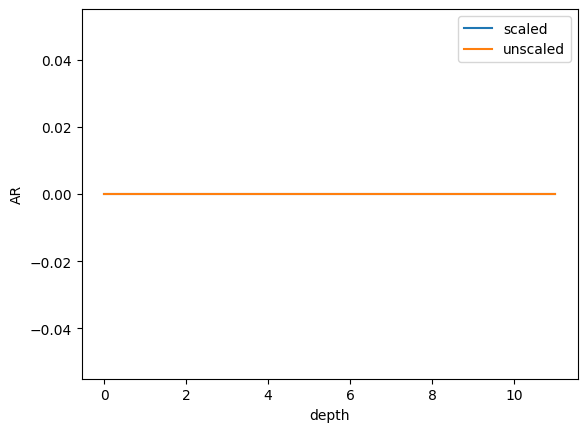

In [9]:
plt.figure()
plt.plot(np.mean(all_AR[:,:,:],axis=(0,1)),label='scaled')
plt.plot(np.mean(all_ori_AR[:,:,:],axis=(0,1)),label='unscaled')
plt.xlabel('depth')
plt.ylabel('AR')
plt.legend()
plt.show()

# different Shot 

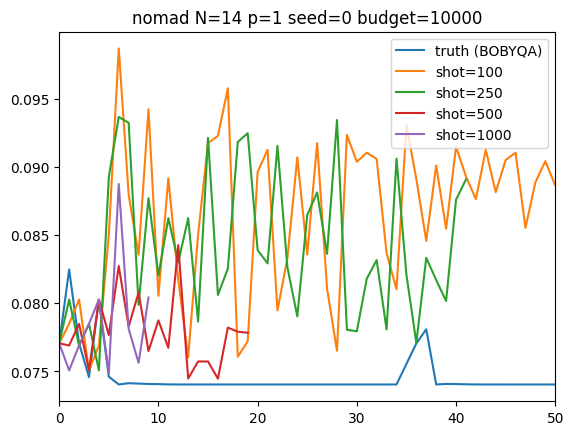

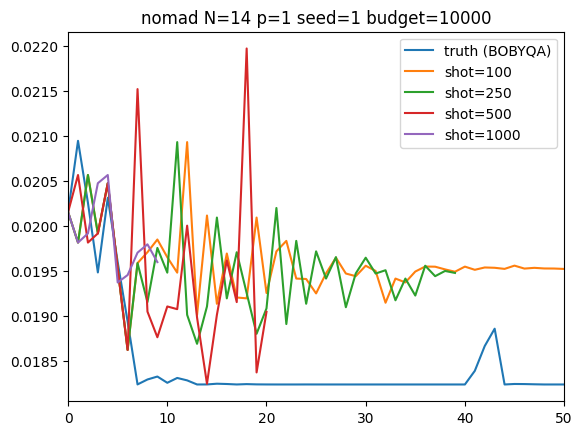

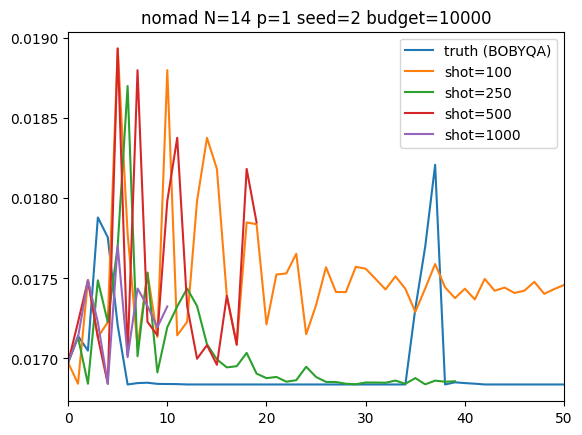

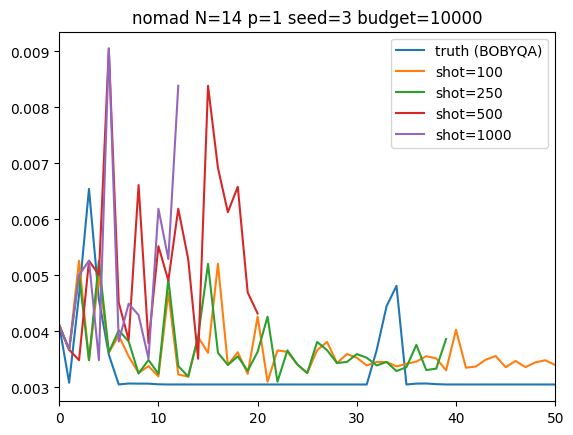

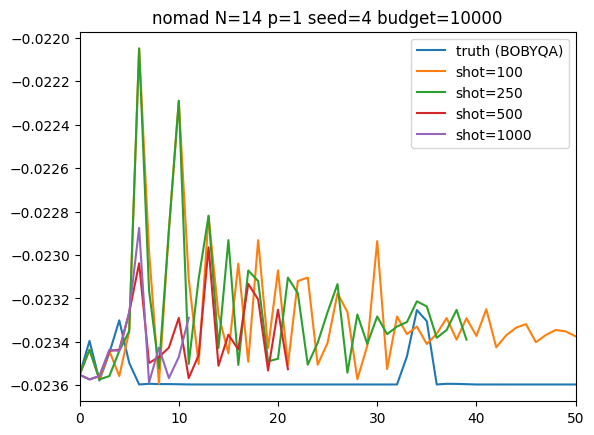

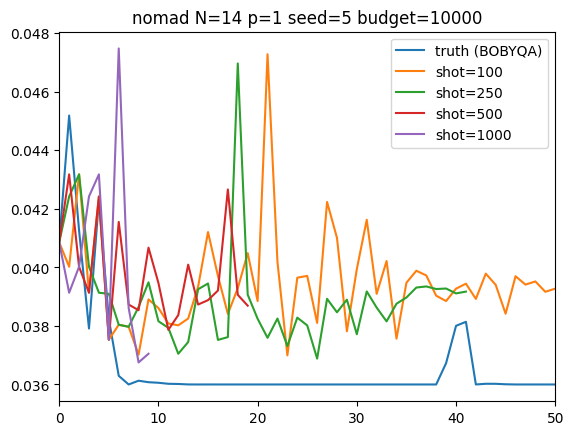

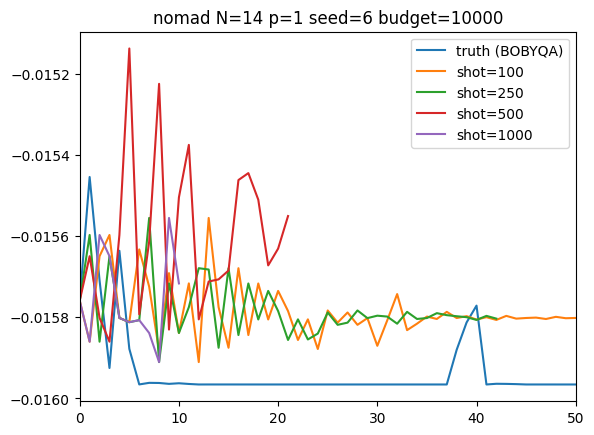

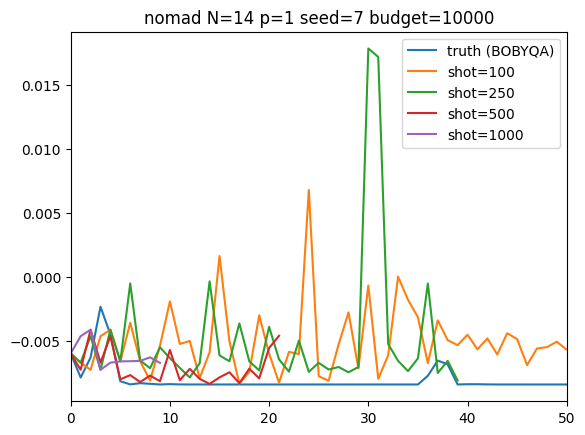

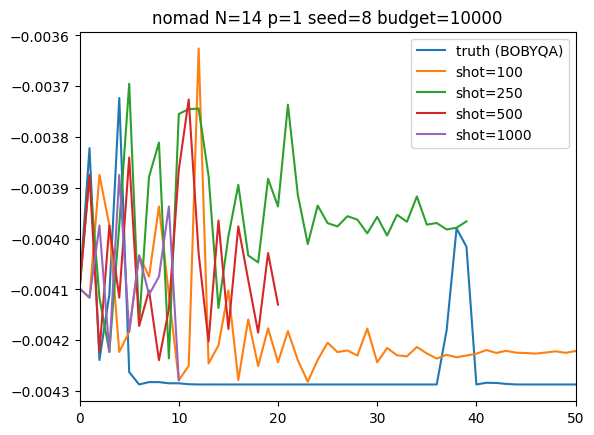

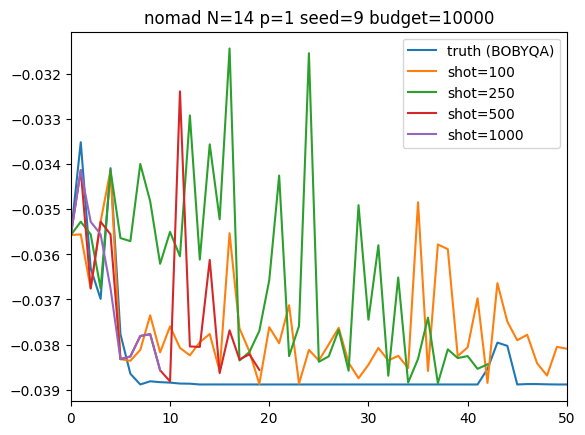

In [36]:
optimizer = 'nomad'
budget = 10000
seed_lst = range(10)
N_lst = [14]
p_lst = [1]
shot_list = [100, 250, 500, 1000]
# all_orig = []
# all_rescaled = []
# all_result = []
n_seed, n_N, n_p, n_shot = len(seed_lst), len(N_lst), len(p_lst), len(shot_list)
# all_AR, all_ori_AR = np.zeros((n_seed,n_N,n_p,n_shot)), np.zeros((n_seed,n_N,n_p,n_shot))
# all_t, all_ori_t = np.zeros((n_seed,n_N,n_p,n_shot)), np.zeros((n_seed,n_N,n_p,n_shot))
for i_s, seed in enumerate(seed_lst):
    for i_n, N in enumerate(N_lst):
        for i_p, p in enumerate(p_lst):
            plt.figure()
            res = pickle.load(open(f"data/traces/bobyqa/{N}_{int(N/2)}_{0.5}_{seed}_p{p}_bobyqa_{budget}eval_Noneshot.pickle", 'rb'))
            plt.plot(res['trace_sv'], label=f'truth (BOBYQA)')
            for shot in shot_list:
                outpath = f"data/traces/{optimizer}/{N}_{int(N/2)}_{0.5}_{seed}_p{p}_{optimizer.lower()}_{budget}eval_{shot}shot.pickle"
                res = pickle.load(open(outpath, 'rb'))
                    # all_AR[i_s,i_n,i_p,i_shot] = res['rescale_ar']
                    # all_ori_AR[i_s,i_n,i_p,i_shot] = res['orig_ar']
                    # all_t[i_s,i_n,i_p,i_shot] = len(res['trace_rescaled'])
                    # all_ori_t[i_s,i_n,i_p,i_shot] = len(res['trace_orig'])
                ### plt.plot(res['res_rescaled'][2], label=f'p={p}')
                if shot is None:
                    shot = 'sv'
                plt.plot(res['trace_sv'], label=f'shot={shot}')
            plt.title(f'{optimizer} {N=} {p=} {seed=} {budget=}')
            plt.legend()
            plt.xlim(0, 50)
            plt.show()

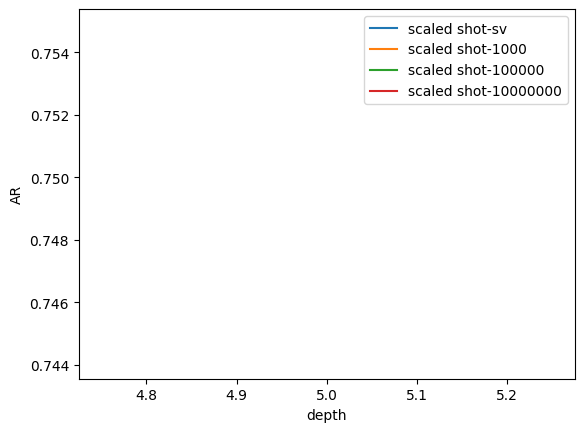

In [ ]:
plt.figure()
for i_shot in range(n_shot):
    # plt.errorbar(p_lst,np.mean(all_AR[:,:,:,i_shot],axis=(0,1)),yerr=np.std(all_AR[:,:,:,i_shot],axis=(0,1)),label=f'scaled shot-{shot_list[i_shot]}')
    plt.plot(p_lst,np.mean(all_AR[:,:,:,i_shot],axis=(0,1)),label=f'scaled shot-{shot_list[i_shot]}')
    # plt.plot(np.mean(all_ori_AR[:,:,:,i_shot],axis=(0,1)),label=f'unscaled shot-{shot_list[i_shot]}')
plt.xlabel('depth')
plt.ylabel('AR')
plt.legend()
plt.show()